## Analysis of A/A/B Testing Results to Improve User Payment Activity

### Key Hypotheses for Analyzing Results
**Null Hypothesis** The adjusted premium subscription price does not affect user payment activity metrics.

**Alternative Hypothesis** The adjusted premium subscription price affects user payment activity metrics. There is a statistically significant difference between the app versions.

To evaluate user payment activity, the following metrics were selected: **premium subscription conversion rate, ARPU, and ARPPU**.

### 1. Data Preparation

In [7]:
!pip install seaborn matplotlib-venn

In [27]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib_venn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [28]:
# Reading files, setting proper data types for time columns, and replacing missing values with zeros to ensure data usability
users_test = pd.read_csv('./dataset/users_test.csv', sep=';')
users_control_1 = pd.read_csv('./dataset/users_control_1.csv', sep=';')
users_control_2 = pd.read_csv('./dataset/users_control_2.csv', sep=';')
transactions_test = pd.read_csv('./dataset/transactions_test.csv', sep=';')
transactions_control_1 = pd.read_csv('./dataset/transactions_control_1.csv', sep=';')
transactions_control_2 = pd.read_csv('./dataset/transactions_control_2.csv', sep=';')

transactions_test['joined_at'] = pd.to_datetime(transactions_test['joined_at'])
transactions_test['paid_at'] = pd.to_datetime(transactions_test['paid_at'])

transactions_control_1['joined_at'] = pd.to_datetime(transactions_control_1['joined_at'])
transactions_control_1['paid_at'] = pd.to_datetime(transactions_control_1['paid_at'])

transactions_control_2['joined_at'] = pd.to_datetime(transactions_control_2['joined_at'])
transactions_control_2['paid_at'] = pd.to_datetime(transactions_control_2['paid_at'])

users_test['is_premium'] = users_test.is_premium.fillna(0).astype('int32')
users_test['was_premium'] = users_test.was_premium.fillna(0).astype('int32')
users_test['coins'] = users_test.coins.fillna(0)

users_control_1['is_premium'] = users_control_1.is_premium.fillna(0).astype('int32')
users_control_1['was_premium'] = users_control_1.was_premium.fillna(0).astype('int32')
users_control_1['coins'] = users_control_1.coins.fillna(0)

users_control_2['is_premium'] = users_control_2.is_premium.fillna(0).astype('int32')
users_control_2['was_premium'] = users_control_2.was_premium.fillna(0).astype('int32')
users_control_2['coins'] = users_control_2.coins.fillna(0)

transactions_control_1['uid'] = users_control_1['uid'].astype('int64')

- The transactions_control_1 file contains 630 empty rows, as well as 3 transactions from 2015. These are removed to align the time period with the A/B test duration (11.01.2017 to 31.10.2017). 
- All transaction files contain fully duplicated rows and incorrect transactions where the payment date is earlier than the user registration date. 
- A mismatch is observed in two files within the same group: for some users, total revenue does not match the sum of transaction revenues. Thus, monetary metrics will be calculated based on transactions. 
- Some users made transactions but are not marked as premium in the user data. Consequently, premium users will only include those with at least one transaction.
- No users are present in multiple groups simultaneously.
> Next, only users and clients meeting the A/B test conditions will be selected: 
  - Users registered after the test started; 
  - Clients who purchased a premium subscription without a trial, as only its price was changed; 
  - Countries with adjusted subscription pricing will match those in transactions_test;
  - It is assumed that the new payment systems correspond to payment IDs 147 and 68, as most subscription transactions were processed through them.
  
  According to these conditions, other countries in the control groups and users with payment ID 0 (likely internal currency purchases) will be excluded. Additionally, discrepancies between user and transaction data in control group 1 will result in the removal of mismatched users.

In [29]:
transactions_control_1 = transactions_control_1.dropna() # Removing empty rows

condition = (transactions_control_1['joined_at'].dt.year == 2015) # Removing data from 2015
transactions_control_1 = transactions_control_1[~condition]

# Removing duplicate rows
def off_duplicates(df):
    if df.duplicated().sum() != 0:
        df = df.drop_duplicates(ignore_index=True)
    return df

transactions_test = off_duplicates(transactions_test)
transactions_control_1 = off_duplicates(transactions_control_1)
transactions_control_2 = off_duplicates(transactions_control_2)

# Removing data where transactions occurred before registration (filtering for new users)
def wrong_trans(df):
    index_to_drop = df[df['paid_at'] < df['joined_at']].index
    df = df.drop(index_to_drop)
    return df

transactions_test = wrong_trans(transactions_test)
transactions_control_1 = wrong_trans(transactions_control_1)
transactions_control_2 = wrong_trans(transactions_control_2)

# Filtering users who purchased a premium subscription without a trial
test_prem = transactions_test.query('product_type == "premium_no_trial"')
control_1_prem = transactions_control_1.query('product_type == "premium_no_trial"')
control_2_prem = transactions_control_2.query('product_type == "premium_no_trial"')

# Filtering countries where the premium subscription price was adjusted
countries = test_prem.country.unique().tolist()
control_1_prem = control_1_prem[control_1_prem.country.isin(countries)]
control_2_prem = control_2_prem[control_2_prem.country.isin(countries)]

all_test = users_test[users_test.country.isin(countries)]
all_control_1 = users_control_1[users_control_1.country.isin(countries)]
all_control_2 = users_control_2[users_control_2.country.isin(countries)]

# Filtering users who made payments through the two payment systems (payment IDs 147 and 68)
test_prem = test_prem[test_prem.payment_id != 0]
control_1_prem = control_1_prem[control_1_prem.payment_id != 0]

# Removing transactions in control group 1 that do not match user data in the same group
control_1_prem = control_1_prem[~control_1_prem.uid.isin(all_control_1.uid.tolist()) == False]

# Dropping unnecessary columns
all_test.drop(columns=['attraction_coeff', 'coins', 'visit_days', 'age_filter_start', 'age_filter_end', 'views_count', 'was_premium', 'is_premium', 'total_revenue'], inplace=True)
all_control_1.drop(columns=['attraction_coeff', 'coins', 'visit_days', 'age_filter_start', 'age_filter_end', 'views_count', 'was_premium', 'is_premium', 'total_revenue'], inplace=True)
all_control_2.drop(columns=['attraction_coeff', 'coins', 'visit_days', 'age_filter_start', 'age_filter_end', 'views_count', 'was_premium', 'is_premium', 'total_revenue'], inplace=True)


Number of unique users <matplotlib_venn._common.VennDiagram object at 0x16c243740>


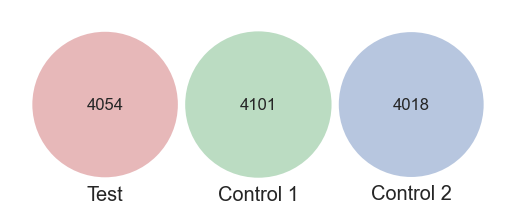

In [30]:
# Identifying overlapping users
print('Number of unique users', matplotlib_venn.venn3(subsets=(set(all_test['uid']), set(all_control_1['uid']), set(all_control_2['uid'])), set_labels=('Test', 'Control 1', 'Control 2')))


Number of unique customers <matplotlib_venn._common.VennDiagram object at 0x16c5edd60>


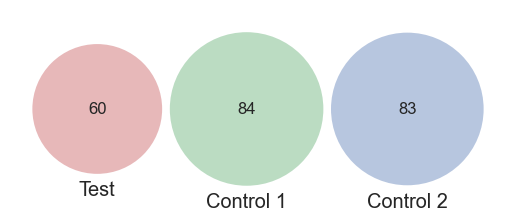

In [31]:
# Finding overlapping premium users
print('Number of unique customers', matplotlib_venn.venn3(subsets=(set(test_prem['uid']), set(control_1_prem['uid']), set(control_2_prem['uid'])), set_labels=('Test', 'Control 1', 'Control 2')))


### 2. Data Overview
 
- No repeated transactions per user in transactions_control_1.
- Age and country distributions among users and customers are relatively similar across groups. The majority of users are from the United States.
- Gender distribution is **uneven** — the majority of users (presumably) are male. However, there are no significant differences between groups.
- A sharp increase in new users was observed in October 2017. The distribution of new users across groups is relatively uniform.

<Axes: title={'center': 'Control 2'}, xlabel='age_group'>

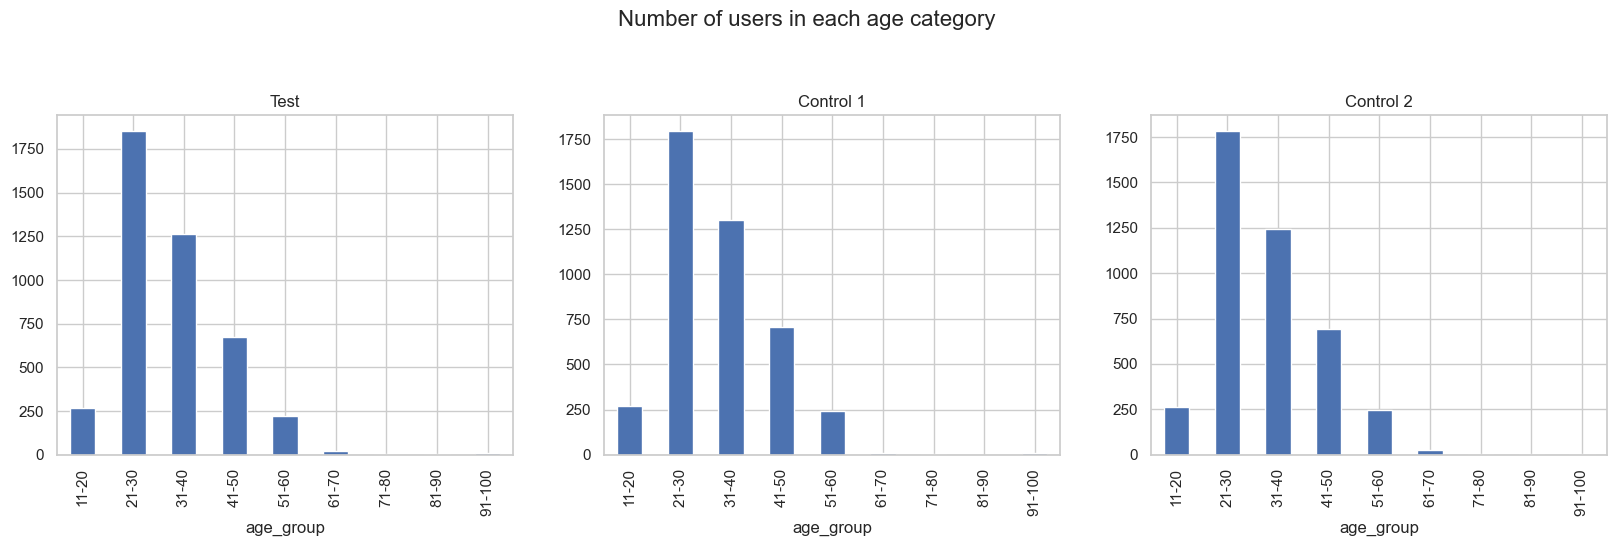

In [32]:
# Categorizing users by age groups
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ["11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"]

users_test['age_group'] = pd.cut(users_test['age'], bins=bins, labels=labels, right=False)
age_groups_test = users_test['age_group'].value_counts().sort_index()
users_control_1['age_group'] = pd.cut(users_control_1['age'], bins=bins, labels=labels, right=False)
age_groups_control_1 = users_control_1['age_group'].value_counts().sort_index()
users_control_2['age_group'] = pd.cut(users_control_2['age'], bins=bins, labels=labels, right=False)
age_groups_control_2 = users_control_2['age_group'].value_counts().sort_index()

# Visualizing age categories in groups
plt.figure(figsize=(20, 15))
plt.suptitle('Number of users in each age category', fontsize=16, y=0.95)
plt.subplot(3, 3, 1)
plt.title('Test')
age_groups_test.plot(kind='bar')

plt.subplot(3, 3, 2)
plt.title('Control 1')
age_groups_control_1.plot(kind='bar')

plt.subplot(3, 3, 3)
plt.title('Control 2')
age_groups_control_2.plot(kind='bar')

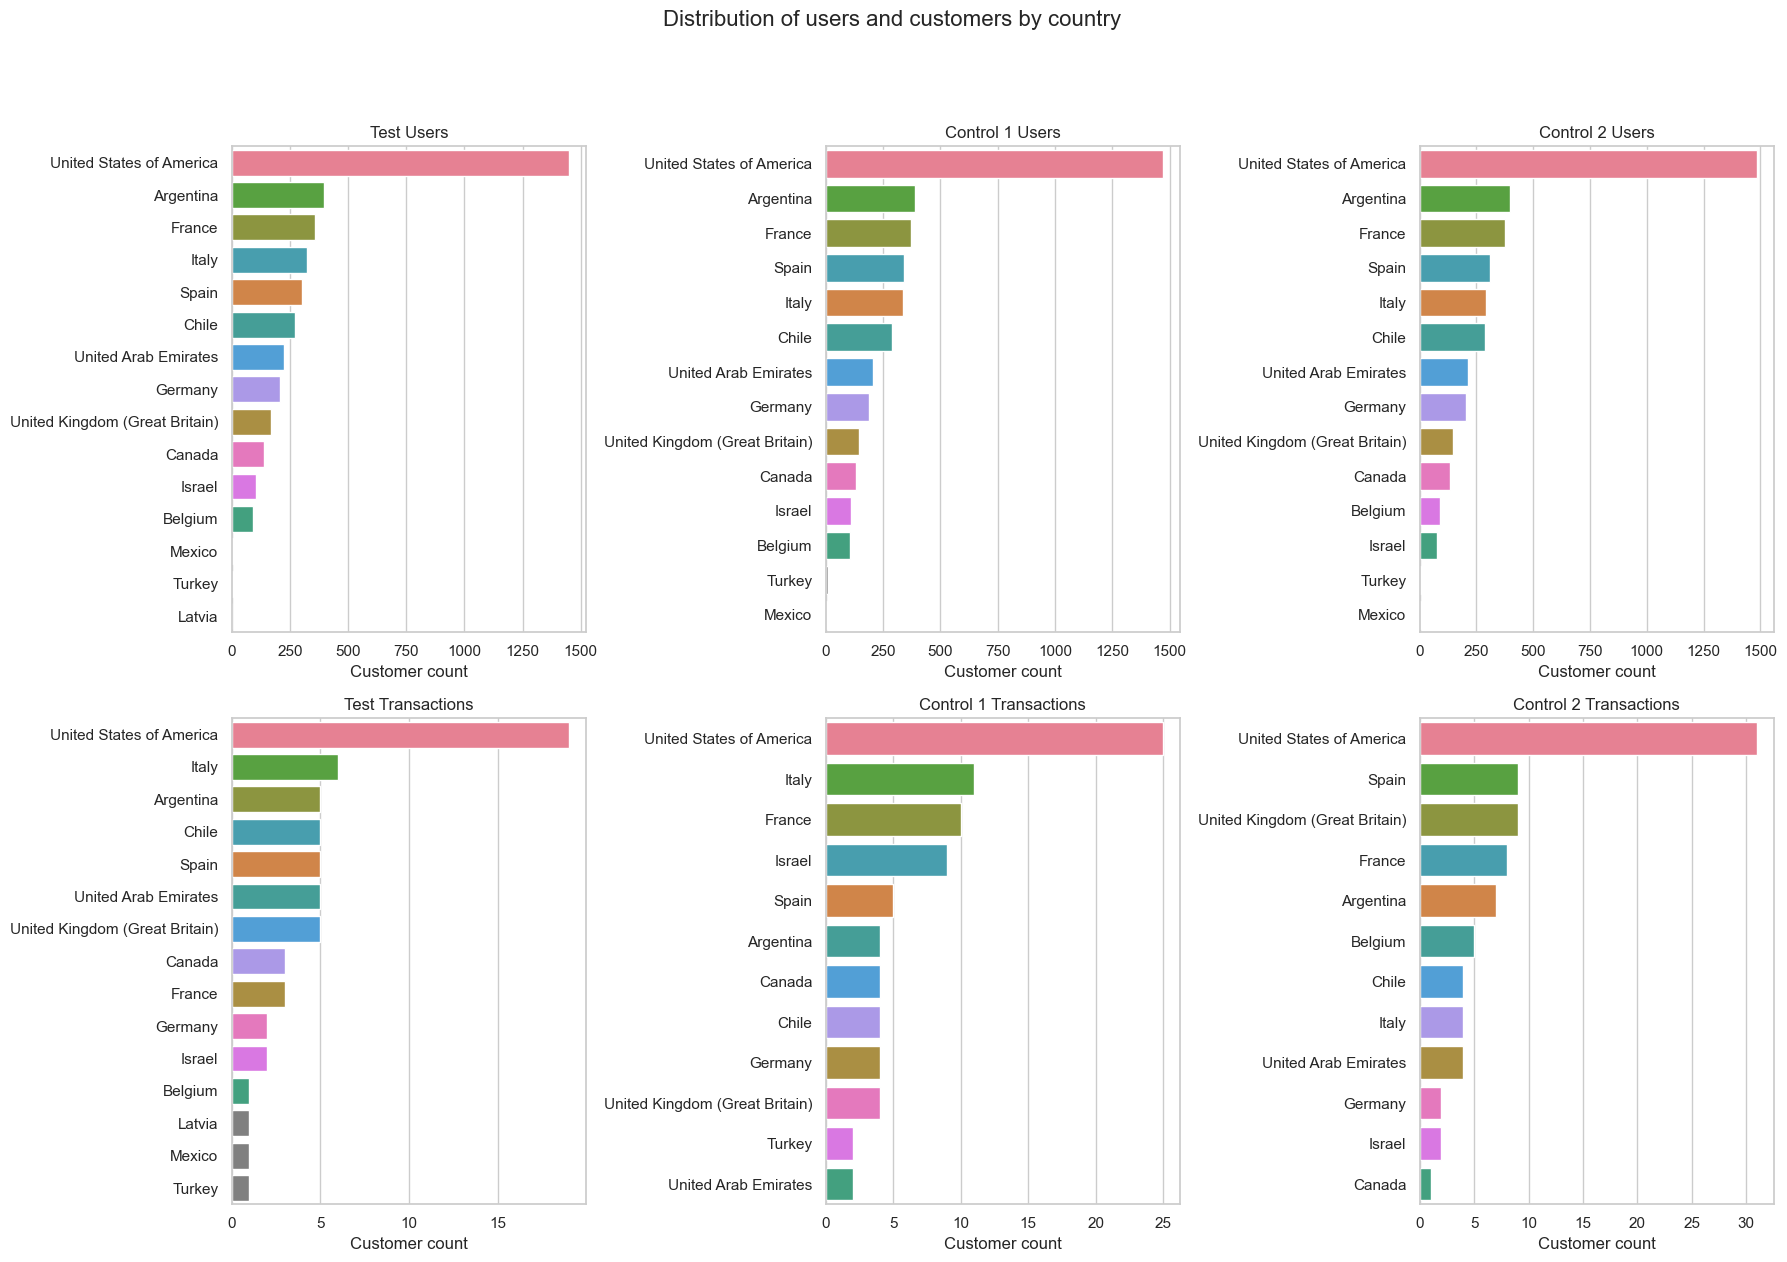

In [33]:
# Preparing data for visualization: grouping by country and counting the number of user
test_countries = all_test.groupby('country', as_index=False) \
                           .agg({'uid': 'count'}) \
                           .sort_values('uid', ascending=False)
control_1_countries = all_control_1.groupby('country', as_index=False) \
                                     .agg({'uid': 'count'}) \
                                     .sort_values('uid', ascending=False)
control_2_countries = all_control_2.groupby('country', as_index=False) \
                                     .agg({'uid': 'count'}) \
                                     .sort_values('uid', ascending=False)


test_tr_countries = test_prem.groupby('country', as_index=False) \
                           .agg({'uid': 'count'}) \
                           .sort_values('uid', ascending=False)
control_1_tr_countries = control_1_prem.groupby('country', as_index=False) \
                                               .agg({'uid': 'count'}) \
                                               .sort_values('uid', ascending=False)
control_2_tr_countries = control_2_prem.groupby('country', as_index=False) \
                                     .agg({'uid': 'count'}) \
                                     .sort_values('uid', ascending=False)

# Visualizing the distribution of users and customers by country across groups
unique_colors = sns.color_palette("husl", len(control_2_tr_countries))
country_colors = dict(zip(control_2_tr_countries['country'], unique_colors))

def create_bar_plot(ax, data, title):
    sns.barplot(x='uid', y='country', data=data, ax=ax, palette=[country_colors.get(country, 'gray') for country in test_countries['country']])
    ax.set_title(title)
    ax.set_xlabel('Customer count')
    ax.set_ylabel('')

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Charts for users
create_bar_plot(axes[0, 0], test_countries, 'Test Users')
create_bar_plot(axes[0, 1], control_1_countries, 'Control 1 Users')
create_bar_plot(axes[0, 2], control_2_countries, 'Control 2 Users')

# Charts for transactions
create_bar_plot(axes[1, 0], test_tr_countries, 'Test Transactions')
create_bar_plot(axes[1, 1], control_1_tr_countries, 'Control 1 Transactions')
create_bar_plot(axes[1, 2], control_2_tr_countries, 'Control 2 Transactions')

plt.suptitle('Distribution of users and customers by country', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [48]:
all_test["gender"] = all_test["gender"].astype(str)
all_control_1["gender"] = all_control_1["gender"].astype(str)
all_control_2["gender"] = all_control_2["gender"].astype(str)

<Axes: title={'center': 'Control 2'}, xlabel='gender', ylabel='count'>

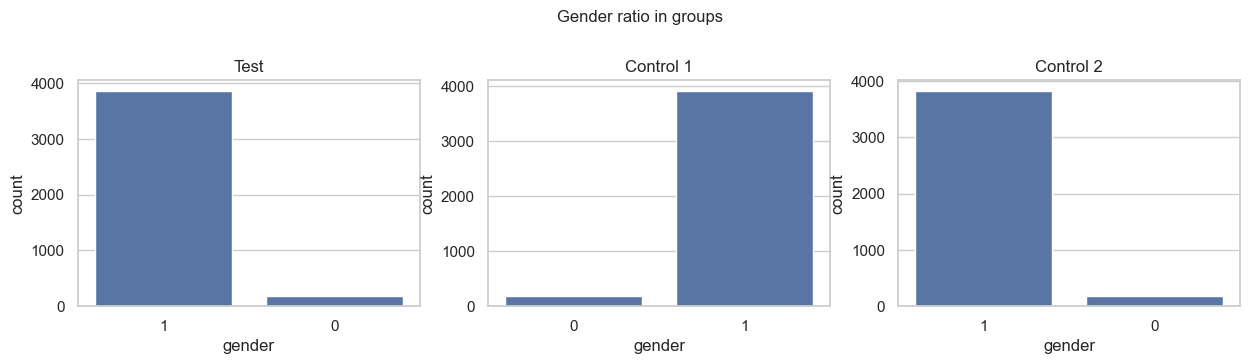

In [47]:
# Visualization of gender distribution across groups
plt.figure(figsize=(15, 10))
plt.suptitle('Gender ratio in groups', fontsize=12, y=0.95)

plt.subplot(3, 3, 1)
plt.title('Test')
sns.countplot(x = all_test.gender)

plt.subplot(3, 3, 2)
plt.title('Control 1')
sns.countplot(x = all_control_1.gender)

plt.subplot(3, 3, 3)
plt.title('Control 2')
sns.countplot(x = all_control_2.gender)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10')])

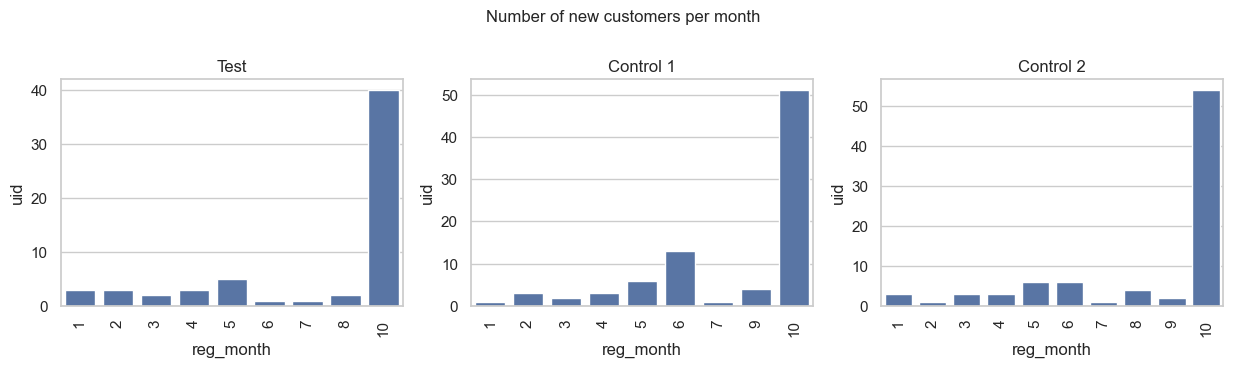

In [35]:
# Preparing data for visualization - grouping by registration month and counting unique customers
test_prem['reg_month'] = test_prem['joined_at'].dt.month
monthly_test = test_prem.groupby('reg_month', as_index=False) \
                        .agg({'uid': 'nunique'})
control_1_prem['reg_month'] = control_1_prem['joined_at'].dt.month
monthly_control_1 = control_1_prem.groupby('reg_month', as_index=False) \
                                  .agg({'uid': 'nunique'})
control_2_prem['reg_month'] = control_2_prem['joined_at'].dt.month
monthly_control_2 = control_2_prem.groupby('reg_month', as_index=False) \
                                  .agg({'uid': 'nunique'})

# Visualization of new customer distribution by month
plt.figure(figsize=(15, 10))
plt.suptitle('Number of new customers per month', fontsize=12, y=0.95)

plt.subplot(3, 3, 1)
plt.title('Test')
sns.barplot(data=monthly_test, x='reg_month', y='uid')
plt.xticks(rotation=90)

plt.subplot(3, 3, 2)
plt.title('Control 1')
sns.barplot(data=monthly_control_1, x='reg_month', y='uid')
plt.xticks(rotation=90)

plt.subplot(3, 3, 3)
plt.title('Control 2')
sns.barplot(data=monthly_control_2, x='reg_month', y='uid')
plt.xticks(rotation=90)

### 3. Data Analysis

> To test the statistical significance of conversion differences between groups, the Chi-square test was selected, as the metric is categorical. The confidence interval was set at 95% (p-value < 0.05).

> To test the statistical significance of differences in ARPU and ARPPU among the three groups, the bootstrap method was used (with a 95% confidence interval), since the data is non-normally distributed (as per the Shapiro-Wilk test, p-value < 0.05), contains noticeable outliers, and has homogeneous variances (Levene's test, p-value > 0.05).

   - **Purchase conversion rates** across all three groups do not differ significantly (p-values = 0.96, 0.05, and 0.05).
   - The confidence intervals for ARPPU and ARPU overlap across the three groups, meaning no statistically significant differences were observed.

In [36]:
# Collection of Key Metrics by Groups
stat = {'groups': ['test', 'control_1', 'control_2'],
        'uniq_users': [all_test.uid.nunique(), all_control_1.uid.nunique(), all_control_2.uid.nunique()],
        'is_premium': [test_prem.uid.nunique(), control_1_prem.uid.nunique(), control_2_prem.uid.nunique()],
        'cr_to_premium': [round(test_prem.uid.nunique() / all_test.uid.nunique() * 100, 1),
                          round(control_1_prem.uid.nunique() / all_control_1.uid.nunique() * 100, 1),
                          round(control_2_prem.uid.nunique() / all_control_2.uid.nunique() * 100, 1)],
        'ARPU':[round(test_prem.revenue.sum() / all_test.uid.nunique() * 100, 0),
                round(control_1_prem.revenue.sum() / all_control_1.uid.nunique() * 100, 0),
                round(control_2_prem.revenue.sum() / all_control_2.uid.nunique() * 100, 0)],
        'ARPPU':[round(test_prem.revenue.sum() / test_prem.uid.nunique() * 100, 0),
                 round(control_1_prem.revenue.sum() / control_1_prem.uid.nunique() * 100, 0),
                 round(control_2_prem.revenue.sum() / control_2_prem.uid.nunique() * 100, 0)]}
stat_df = pd.DataFrame(stat)
stat_df

,groups,uniq_users,is_premium,cr_to_premium,ARPU,ARPPU
0,test,4054,60,1.5,17701.0,1196022.0
1,control_1,4101,84,2.0,16062.0,784163.0
2,control_2,4018,83,2.1,15749.0,762411.0


3.1 Testing for Statistical Significance in **Purchase Conversion:**
> **H0**: The two compared samples belong to the same population, and there is no difference in purchase conversion between groups. 
>
> **H1**: The two compared samples do not belong to the same population, and purchase conversion differs significantly between groups. 

In [18]:
# Assessment of Statistical Significance of Differences in Premium Subscription Purchase Conversion Between the Two Control Groups
controls_1_2 = np.array([[stat_df[stat_df.groups == 'control_1'].is_premium, stat_df[stat_df.groups == 'control_1'].uniq_users - stat_df[stat_df.groups == 'control_1'].is_premium], 
                         [stat_df[stat_df.groups == 'control_2'].is_premium, stat_df[stat_df.groups == 'control_2'].uniq_users - stat_df[stat_df.groups == 'control_2'].is_premium]])
print('p-value of CRs of 1 and 2 control groups is', scipy.stats.chi2_contingency(controls_1_2,correction=False)[1])

# Assessment of Statistical Significance of Differences in Premium Subscription Purchase Conversion Between the First Control Group and the Test Group
controls_1_test = np.array([[stat_df[stat_df.groups == 'control_1'].is_premium, stat_df[stat_df.groups == 'control_1'].uniq_users - stat_df[stat_df.groups == 'control_1'].is_premium], 
                         [stat_df[stat_df.groups == 'test'].is_premium, stat_df[stat_df.groups == 'test'].uniq_users - stat_df[stat_df.groups == 'test'].is_premium]])
print('p-value of CRs of 1 control and test group is', scipy.stats.chi2_contingency(controls_1_test,correction=False)[1])

# Assessment of Statistical Significance of Differences in Premium Subscription Purchase Conversion Between the Second Control Group and the Test Group
controls_2_test = np.array([[stat_df[stat_df.groups == 'control_2'].is_premium, stat_df[stat_df.groups == 'control_2'].uniq_users - stat_df[stat_df.groups == 'control_2'].is_premium], 
                         [stat_df[stat_df.groups == 'test'].is_premium, stat_df[stat_df.groups == 'test'].uniq_users - stat_df[stat_df.groups == 'test'].is_premium]])
print('p-value of CRs of 2 control and test group is', scipy.stats.chi2_contingency(controls_2_test,correction=False)[1])

p-value of CRs of 1 and 2 control groups is 0.9558981373412331
p-value of CRs of 1 control and test group is 0.05139716852272169
p-value of CRs of 2 control and test group is 0.04610247944799621


3.2 Assessment of Statistical Significance of Differences in **ARPPU**:
> **H0**: There is no statistically significant difference in the average ARPPU values between the three groups. 
>
> **H1**: There is a statistically significant difference in the average ARPPU values in at least one pair of groups.

In [19]:
# Preparing Data for Analysis
arppu_test = test_prem.groupby('uid', as_index=False).revenue.sum()
arppu_control_1 = control_1_prem.groupby('uid', as_index=False).revenue.sum()
arppu_control_2 = control_2_prem.groupby('uid', as_index=False).revenue.sum()

<Axes: title={'center': 'Control 2'}, xlabel='revenue', ylabel='Count'>

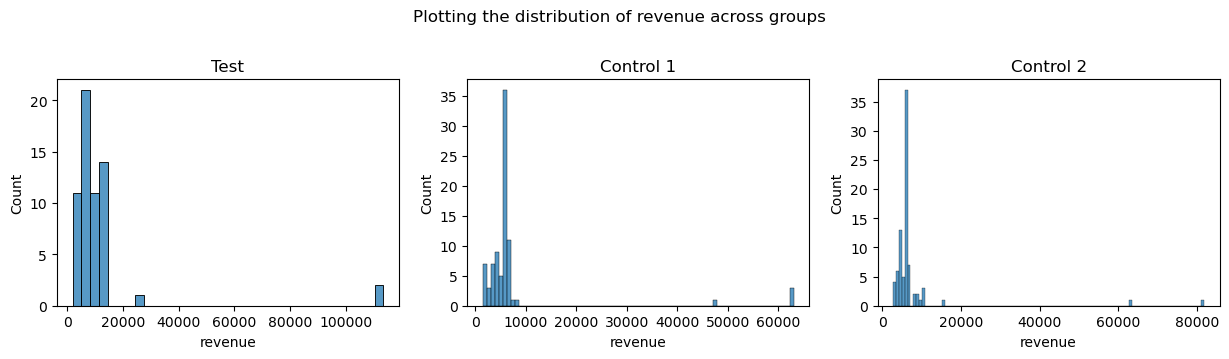

In [20]:
# Data Distribution Visualization
plt.figure(figsize=(15, 10))
plt.suptitle('Plotting the distribution of revenue across groups', fontsize=12, y=0.95)

plt.subplot(3, 3, 1)
plt.title('Test')
sns.histplot(arppu_test.revenue)

plt.subplot(3, 3, 2)
plt.title('Control 1')
sns.histplot(arppu_control_1.revenue)

plt.subplot(3, 3, 3)
plt.title('Control 2')
sns.histplot(arppu_control_2.revenue)

In [21]:
# Normality Test for All Three Groups
print('When testing the distribution of RPPU test for normality, p-value =', stats.shapiro(arppu_test.revenue).pvalue)
print('When testing the distribution of RPPU control 1 for normality, p-value =', stats.shapiro(arppu_control_1.revenue).pvalue)
print('When testing the distribution of RPPU control 2 for normality, p-value =', stats.shapiro(arppu_control_2.revenue).pvalue)

When testing the distribution of RPPU test for normality, p-value = 4.237656877765681e-15
When testing the distribution of RPPU control 1 for normality, p-value = 8.207207930415707e-18
When testing the distribution of RPPU control 2 for normality, p-value = 2.0325592228670823e-18


In [22]:
# Test for homogeneity of variances
stats.levene(arppu_control_1.revenue, arppu_control_2.revenue, arppu_test.revenue)

LeveneResult(statistic=1.2833982121106242, pvalue=0.2791235586430493)

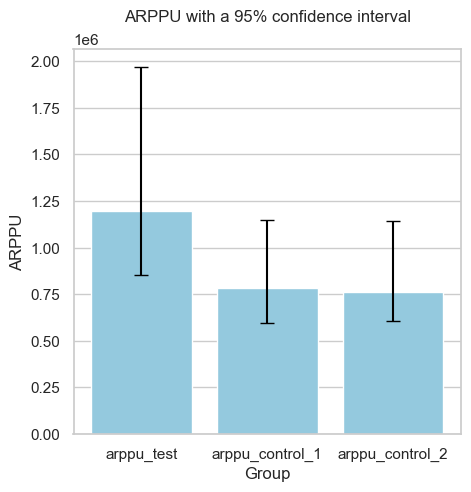

In [23]:
# Data preparation for bootstrap
bs_test_arppu_sample = arppu_test.revenue.tolist()
bs_control_1_arppu_sample = arppu_control_1.revenue.tolist()
bs_control_2_arppu_sample = arppu_control_2.revenue.tolist()

# Function to calculate ARPPU in bootstrap
def calculate_arppu(sample):
    return sum(sample)/len(sample)*100

# Bootstrap of all groups
res_test = scipy.stats.bootstrap((bs_test_arppu_sample,), calculate_arppu, vectorized=False)
res_control_1 = scipy.stats.bootstrap((bs_control_1_arppu_sample,), calculate_arppu, vectorized=False)
res_control_2 = scipy.stats.bootstrap((bs_control_2_arppu_sample,), calculate_arppu, vectorized=False)

# Visualization of bootstrap results
arppus = {'arppu_test': stat_df[stat_df['groups'] == 'test']['ARPPU'].squeeze(), 
                    'arppu_control_1': stat_df[stat_df['groups'] == 'control_1']['ARPPU'].squeeze(), 
                    'arppu_control_2': stat_df[stat_df['groups'] == 'control_2']['ARPPU'].squeeze()}

confidence_intervals = {
    'arppu_test': {'low': res_test.confidence_interval.low, 'high': res_test.confidence_interval.high},
    'arppu_control_1': {'low': res_control_1.confidence_interval.low, 'high': res_control_1.confidence_interval.high},
    'arppu_control_2': {'low': res_control_2.confidence_interval.low, 'high': res_control_2.confidence_interval.high}}

data = {'Group': [], 'ARPPU': [], 'Lower CI': [], 'Upper CI': []}
for group, arppu in arppus.items():
    data['Group'].append(group)
    data['ARPPU'].append(arppu)
    data['Lower CI'].append(confidence_intervals[group]['low'])
    data['Upper CI'].append(confidence_intervals[group]['high'])

df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.figure(figsize=(5, 5))
sns.barplot(x='Group', y='ARPPU', data=df, color='skyblue')
plt.errorbar(x=df['Group'], y=df['ARPPU'],
             yerr=[df['ARPPU'] - df['Lower CI'], df['Upper CI'] - df['ARPPU']],
             fmt='none', ecolor='black', capsize=5, capthick=1)

plt.title('ARPPU with a 95% confidence interval', y=1.05)
plt.xlabel('Group')
plt.ylabel('ARPPU')
plt.show()


3.3 Checking statistical significance of differences in **ARPU**:
> **H0**: There is no statistically significant difference in the average ARPU between the three groups. 
>
> **H1**: There is a statistically significant difference in the average ARPU in at least one pair of groups.

In [24]:
# Data preparation for analysis
all_test = all_test.merge(arppu_test, how='left', on='uid')
all_test = all_test.fillna(0)

all_control_1 = all_control_1.merge(arppu_control_1, how='left', on='uid')
all_control_1 = all_control_1.fillna(0)

all_control_2 = all_control_2.merge(arppu_control_2, how='left', on='uid')
all_control_2 = all_control_2.fillna(0)

In [25]:
# Test for homogeneity of variances
stats.levene(all_control_1.revenue, all_control_2.revenue, all_test.revenue)

LeveneResult(statistic=0.0889615862956226, pvalue=0.9148813118011769)

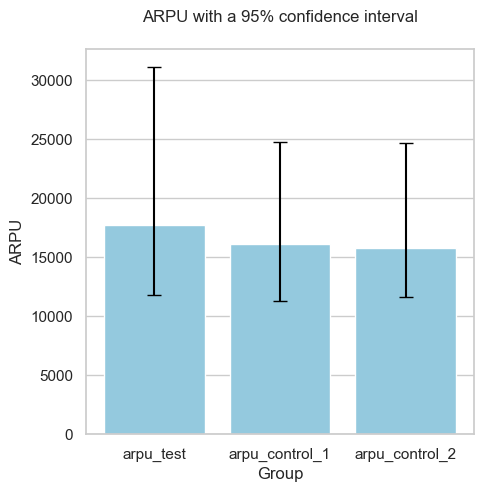

In [26]:
# Data preparation for bootstrap
bs_test_arpu_sample = all_test.revenue.tolist()
bs_control_1_arpu_sample = all_control_1.revenue.tolist()
bs_control_2_arpu_sample = all_control_2.revenue.tolist()

# Function to calculate convertion in bootstrap
def calculate_arpu(sample):
    return sum(sample)/len(sample)*100

# Bootstrap of all groups
res_test = scipy.stats.bootstrap((bs_test_arpu_sample,), calculate_arpu, vectorized=False)
res_control_1 = scipy.stats.bootstrap((bs_control_1_arpu_sample,), calculate_arpu, vectorized=False)
res_control_2 = scipy.stats.bootstrap((bs_control_2_arpu_sample,), calculate_arpu, vectorized=False)

# Visualization of bootstrap results
arpus = {'arpu_test': stat_df[stat_df['groups'] == 'test']['ARPU'].squeeze(), 
                    'arpu_control_1': stat_df[stat_df['groups'] == 'control_1']['ARPU'].squeeze(), 
                    'arpu_control_2': stat_df[stat_df['groups'] == 'control_2']['ARPU'].squeeze()}

confidence_intervals = {
    'arpu_test': {'low': res_test.confidence_interval.low, 'high': res_test.confidence_interval.high},
    'arpu_control_1': {'low': res_control_1.confidence_interval.low, 'high': res_control_1.confidence_interval.high},
    'arpu_control_2': {'low': res_control_2.confidence_interval.low, 'high': res_control_2.confidence_interval.high}}

data = {'Group': [], 'ARPU': [], 'Lower CI': [], 'Upper CI': []}
for group, arpu in arpus.items():
    data['Group'].append(group)
    data['ARPU'].append(arpu)
    data['Lower CI'].append(confidence_intervals[group]['low'])
    data['Upper CI'].append(confidence_intervals[group]['high'])

df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.figure(figsize=(5, 5))
sns.barplot(x='Group', y='ARPU', data=df, color='skyblue')
plt.errorbar(x=df['Group'], y=df['ARPU'],
             yerr=[df['ARPU'] - df['Lower CI'], df['Upper CI'] - df['ARPU']],
             fmt='none', ecolor='black', capsize=5, capthick=1)

plt.title('ARPU with a 95% confidence interval', y=1.05)
plt.xlabel('Group')
plt.ylabel('ARPU')
plt.show()


### 4. Conclusion:
#### Based on the results of the statistical analysis of the A/B test data, it can be concluded that the changes implemented in the test group did not lead to statistically significant changes in conversion to purchase, ARPPU, or ARPU compared to the control groups.